In [3]:
from pettingzoo.classic import tictactoe_v3
from pettingzoo.classic import uno_v4
import random
import numpy as np
from collections import defaultdict
import dill

In [5]:
import hashlib

def encode_state(observation):
    # encode observation as bytes           
    obs_bytes = str(observation).encode('utf-8')
    # create md5 hash
    m = hashlib.md5(obs_bytes)
    # return hash as hex digest
    state = m.hexdigest()
    return(state)

In [13]:
def epsilon_greedy_policy(nA, Q, agent, action_mask, state, epsilon):

    action_values = Q[agent][state]
    
    greedy_action = np.argmax(action_values)
    
    probabilities = np.ones(nA) * epsilon / nA
    
    probabilities[greedy_action] += (1 - epsilon)
    probabilities *= action_mask
    z = probabilities.sum()
    probabilities = probabilities / z
    possible_choices = np.array(range(nA))
#     print(probabilities)
    action = np.random.choice(possible_choices, p=probabilities)
    
    return action

In [7]:
def update_Q_value(Q, agent, previous_state, previous_action, \
                   reward, alpha, gamma, current_state=None):
    
    qval = Q[agent][previous_state][previous_action]
    if current_state:
        Q[agent][previous_state][previous_action] = qval\
        + alpha*(reward + gamma*np.max(Q[agent][current_state]) - qval)
        
    return Q

In [8]:
import tqdm
def marl_q_learning(multi_env, num_episodes, alpha, gamma=1.0, \
                    eps_start=1.0, eps_decay=.99999, \
                        eps_min=0.025, pre_trained_Q=None):
    # sanity check size of Q.
    multi_env.reset()
    if pre_trained_Q:
        Q = pre_trained_Q
    else:
        Q = {}
    for agent in multi_env.agents:    
        nA = multi_env.action_space(agent).n
        Q[agent] = defaultdict(lambda: np.zeros(nA))
    
    epsilon = eps_start

    i_episode = 1    

    prev_state = {'player_1': -1,
                  'player_2': -1}
    prev_action = {'player_1': -1,
                  'player_2': -1}
    
    p1_size = np.array([])
    p2_size = np.array([])

    # keeps iterating over active agents until num episode break
    for i_episode in tqdm.tqdm(range(num_episodes)):
        for agent in multi_env.agent_iter():        
            
            # get observation (state) for current agent:
            observation, reward, done, info = multi_env.last()
            
            # perform q-learning with update_Q_value()
            # your code here
            state = encode_state(env.render(mode="ansi"))
            Q = update_Q_value(Q, agent, prev_state[agent], prev_action[agent], reward, \
                           alpha, gamma, current_state=state)
            p1_size = np.append(p1_size, len(Q["player_1"]))
            p2_size = np.append(p2_size, len(Q["player_2"]))
                                
            # store current state
            prev_state[agent] = state
            
            if not done: 
                # choose action using epsilon_greedy_policy()
                # your code here
                action = epsilon_greedy_policy(nA, Q, agent, observation["action_mask"], state, epsilon)
                multi_env.step(action)
                
                # store chosen action
                prev_action[agent] = action 
            else: 
                # agent is done
                multi_env.step(None)
        
        
        # reset env and memory
        multi_env.reset()
        prev_state = {'player_1': -1,
                      'player_2': -1}
        prev_action = {'player_1': -1,
                       'player_2': -1}
        # bump episode
        i_episode += 1
        # decrease epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
#     print(Q)
    return Q, p1_size, p2_size

In [34]:
env = tictactoe_v3.env()

np.random.seed(123)

fullrun = 0
steps = 100_000


path = "/home/jaoi/master22/petting_for_sale/petting_examples/cached/Q{}.pkl".format(steps)


if fullrun:

    Q, p1, p2 = marl_q_learning(env, steps, alpha = 0.6, gamma = 0.95, eps_start=0.2)
    # print(Q)
#     print(N)
    with open(path, 'wb') as f:
        dill.dump(Q, f)    

else:
    with open(path, 'rb') as f:
        Q = dill.load(f)   
# print(Q)

In [15]:
def rand_policy(observation, agent):
    action = random.choice(np.flatnonzero(observation['action_mask']))
    return action

In [39]:
def play_states(env, games=10000):
    c = defaultdict(int)
    for game in range(games):
        env.reset()
        agents = list(env.agents)

        for agent in env.agent_iter():
            state = encode_state(env.render(mode="ansi"))
            observation, reward, done, info = env.last()
            
            if agent == "player_1":
                nA = env.action_space(agent).n
                # action = rand_policy(observation, agent) if not done else None
                # epsilon er hvor mye randomness som skal med, 1.0 er alltid random, 0.001 er 0.1 % random
                action = epsilon_greedy_policy(nA, Q, agent, observation["action_mask"], state, epsilon=0.001) if not done else None
            elif agent == "player_2":
                # action = rand_policy(observation, agent) if not done else None
                nA = env.action_space(agent).n
                action = epsilon_greedy_policy(nA, Q, agent, observation["action_mask"], state, epsilon=0.001) if not done else None
                
                
            env.step(action)
            
            if reward != 0 and len(env.agents) > 0:
                c[env.agents[0] + "wins"] += 1
                agents.remove(env.agents[0])
                c[agents[0]+"losses"] += 1
                break
            elif len(env.agents) == 0:
                c["draws"] += 1
    return c

c = play_states(env)
c

defaultdict(int,
            {'player_1wins': 9991,
             'player_2losses': 9991,
             'player_2wins': 4,
             'player_1losses': 4,
             'draws': 5})

p1


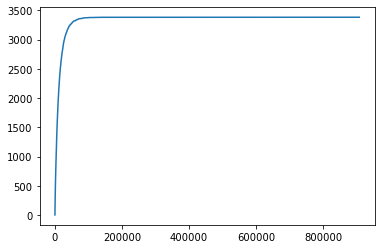

p2


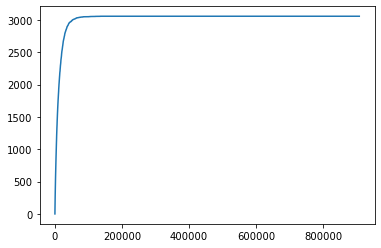

In [21]:
import matplotlib.pyplot as plt

x = np.array(np.arange(len(p1)))

print("p1")
plt.plot(x, p1)
plt.show()

print("p2")
plt.plot(x, p2)
plt.show()


In [40]:
env.reset()
state = encode_state(env.render(mode="ansi"))
print(env.action_space("player_1").n)
print(env.render())
Q["player_1"][state]

9
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
None


array([0.72835808, 0.72395795, 0.81864091, 0.80701924, 0.79638125,
       0.76456856, 0.87014091, 0.83063783, 0.58903635])

In [19]:
c1 = defaultdict(int)
c2 = defaultdict(int)

b = 0
for k, v in Q["player_1"].items():
    print(k, v)
    b += 1
    if b == 2:
        break

for k, v in Q["player_1"].items():
    c1[len(v)] += 1
    
for k, v in Q["player_2"].items():
    c2[len(v)] += 1
    

print(c1)
print(c2)

-1 [0.         0.         0.         0.         0.         0.
 0.         0.         0.82478967]
e1d184b7c70f608e0f7ed1c41067d461 [0.72835808 0.72395795 0.81864091 0.80701924 0.79638125 0.76456856
 0.87014091 0.83063783 0.58903635]
defaultdict(<class 'int'>, {9: 3382})
defaultdict(<class 'int'>, {9: 3056})


In [17]:
possible_agents = ["player_1", "player_2", "player_3"]
agent_name_mapping = dict(zip(possible_agents, list(range(len(possible_agents)))))
agent_name_mapping


{'player_1': 0, 'player_2': 1, 'player_3': 2}

In [21]:
env = uno_v4.env()
env.reset()
for agent in env.agents:
    obs, reward, done, info = env.last()
    print(obs["action_mask"])
    print(env.render())
    print(env.step(2))

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0]


=============== player_0's Hand ===============
Wild, Skip, 4, 9, Draw-2, 7, Reverse

=============== player_1's Hand ===============
6, Skip, 2, 6, 2, 9, 1

================= Target Card =================
9

None
[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
None
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0]


=============== player_0's Hand ===============
Wild, Skip, 4, 9, Draw-2, 7, Reverse

=============== player_1's Hand ===============
6, Skip, 2, 6, 2, 9, 1

================= Target Card =================
9

None


ValueError: when an agent is done, the only valid action is None